['segpc2021_2c_multiresunet', 'isic2018_uctransnet_9', 'segpc2021_2c_adaptuctransnet_7', 'isic2018_uctransnet_7', 'segpc2021_transunet', 'segpc2021_unet', 'isic2018_multiresunet', 'isic2018_uctransnet_5', 'segpc2021_unetpp', 'isic2018_unet.yaml', 'segpc_c_adapt_unet', 'segpc2021_uctransnet', 'segpc_cn_unet.yaml', 'segpc2021_2c_attunet', 'segpc2021_multiresunet', 'isic2018_uctransnet', 'segpc_c_acda_unet', 'isic2018_uctransnet_15', 'isic2018_unet', 'segpc2021_attunet', 'segpc_c_unet.yaml', 'isic2018_uctransnet_19', 'segpc_c_unet', 'segpc2021_resunet', 'isic2018_resunet', 'isic2018_uctransnet_17', 'segpc2021_uctransnet_13', 'isic2018_adaptuctransnet_7', 'segpc2021_adaptconv_uctransnet_3', 'isic2018_uctransnet_21', 'segpc2021_2c_transunet', 'segpc2021_2c_uctransnet', 'segpc2021_uctransnet_11', 'isic2018_uctransnet_3', 'segpc2021_2c_unet', 'segpc2021_uctransnet_5', 'segpc2021_uctransnet_9', 'isic2018_uctransnet_11', 'segpc2021_uctransnet_7', 'isic2018_uctransnet_13', 'segpc_n_unet.yaml', '

interactive(children=(Dropdown(description='dataset', options=('segpc_c', 'isic2018', 'segpc_cn', 'segpc_n'), …

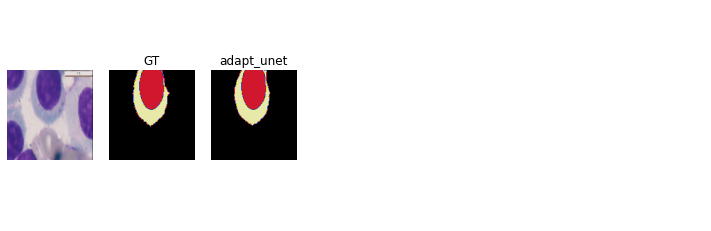

In [71]:
import sys,json
import pandas as pd
sys.path.append('../..')
from utils import (
    show_sbs,
    load_config,
    _print,
)

import os
import ipywidgets as widgets

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchmetrics
from torch.optim import Adam, SGD
from losses import DiceLoss, DiceLossWithLogtis
from torch.nn import BCELoss, CrossEntropyLoss
import ali_utils

# Set the directory path
directory = '../../saved_models/'

# Get the list of files in the directory
file_list = os.listdir(directory)
print(file_list)
from tqdm import tqdm
import numpy as np
from torch.utils.data import DataLoader, Subset
from torchvision import transforms
img_transform = transforms.Compose([ transforms.ToTensor()])
# transform for mask
msk_transform = transforms.Compose([transforms.ToTensor()])
msk_transform = torch.tensor

from PIL import Image
import cv2
def get_model(model_dir):
    config=load_config(f'{model_dir}/config.yaml')
    device = 'cpu'#torch.device("cuda" if torch.cuda.is_available() else "cpu")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Torch device: {device}")



    best_model = ali_utils.class_by_name(config['model']['class'])(**config['model']['params'])

    torch.cuda.empty_cache()
    best_model = best_model.to(device)

    fn = "best_model_state_dict.pt"
    model_path = f"{model_dir}/{fn}"

    best_model.load_state_dict(torch.load(model_path))
    print("Loaded best model weights...")
    return best_model

from matplotlib import pyplot as plt
@widgets.interact
def datasets(dataset=os.listdir('ali_configs_new')):
    dataset_config=load_config(f'ali_configs_new/{dataset}/_dataset.yaml')
    dataset_config={**dataset_config, **load_config(f'ali_configs_new/{dataset}/_common.yaml')}
    te_dataset = ali_utils.class_by_name(dataset_config['dataset']['class'])(mode="te", **dataset_config['dataset'],img_transform=img_transform,msk_transform=msk_transform)
    print(te_dataset.number_classes,dataset_config['dataset'])
    
    import ipyplot
    @widgets.interact
    def select_case(image_number=widgets.IntSlider(0,0,len(te_dataset))):
        item=te_dataset[image_number]
        img,msk=item['image'].cpu().numpy().astype('float32'),item['mask'].cpu().numpy().astype('float32')
        
        print(img.shape)
        fig, axs = plt.subplots(1, te_dataset.number_classes, sharex=True, sharey=True)
        fig.set_size_inches(1000/80, fig.get_figheight())

        imgv=img=np.transpose(img,(1, 2, 0))
        print(imgv.shape)
        if img.shape[-1]==4:
            imgv=img[...,:-1]
            print(imgv.shape)

        nonzero = np.where(imgv != 0)
        roi=np.zeros((imgv.ndim,2))
        for i in range(len(nonzero)):
            if len(nonzero[i]) > 0:
                roi[i][0] = max(0, nonzero[i].min())
                roi[i][1] = min( imgv.shape[i], nonzero[i].max() + 1)
                
        axs[0].imshow(imgv)
        axs[0].set_xlim(roi[1][0], roi[1][1])
        axs[0].set_ylim(roi[0][0], roi[0][1])
        # print(img.shape)
        # debug_imgs=[img]
        if(dataset.startswith('segpc')):
            added=(img[...,-1]>0)*.1
        # plt.imshow(imgs[image_number][:,:,:-1])
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        for i in range(1,te_dataset.number_classes):
            # plt.imshow(imgs[-1,0:3])
            # debug_imgs.append(msk[i])
            axs[i].imshow(msk[i]+added,cmap='gist_stern')
            print(f'clsss:{i}',msk[i].max())
        # ipyplot.plot_images(debug_imgs, max_images=4, img_width=150)
        @widgets.interact_manual
        def compare(dirs=widgets.SelectMultiple(options=[f for f in file_list if f.startswith(dataset)], description='Files',           layout=widgets.Layout(width='100%', height='180px')),titles="comma seperated"):
            fig, axs = plt.subplots(1, len(dirs)+2, sharex=True, sharey=True)
            fig.set_size_inches(1000/80, fig.get_figheight())
            
            axs[0].imshow(imgv)
            axs[0].set_xlim(roi[1][0], roi[1][1])
            axs[0].set_ylim(roi[0][0], roi[0][1])
            axs[1].set_title('GT')
            plt.axis('off')
            for i in range(len(axs)):
                axs[i].axis('off')
            
            axs[1].imshow(np.argmax(msk,0)+added, cmap='gist_stern')
            allmetrics={}
            for i,d in enumerate(dirs):
                display_name=d.replace(dataset+"_",'')
                model=get_model(f'{directory}/{d}')
                
                prepared=torch.stack([transforms.ToTensor()(img).to(device)])
                
                preds=model(prepared)
                pred=preds.detach().cpu().numpy()[0][1,...]
                # print(pred.shape)
                # print(pred.max())
                axs[i+2].imshow((pred>0.5)+added, cmap='gist_stern')
                axs[i+2].set_title(display_name)
                with open(f'{directory}/{d}/result.json', 'r') as f:
                    results = json.load(f)
                allmetrics[display_name] = {k.split('/')[-1]:v for k,v in results['best_result']['te_metrics'].items()}

            display(pd.DataFrame(allmetrics).T.round(4))

            plt.tight_layout()
            plt.show()  



In [26]:
img.shape

NameError: name 'img' is not defined